This follows Caroline's example of the "Michaelis-Menten Model Calibration Example"

#### mRNA Self-Regulation Model from Liepe et al 2014 

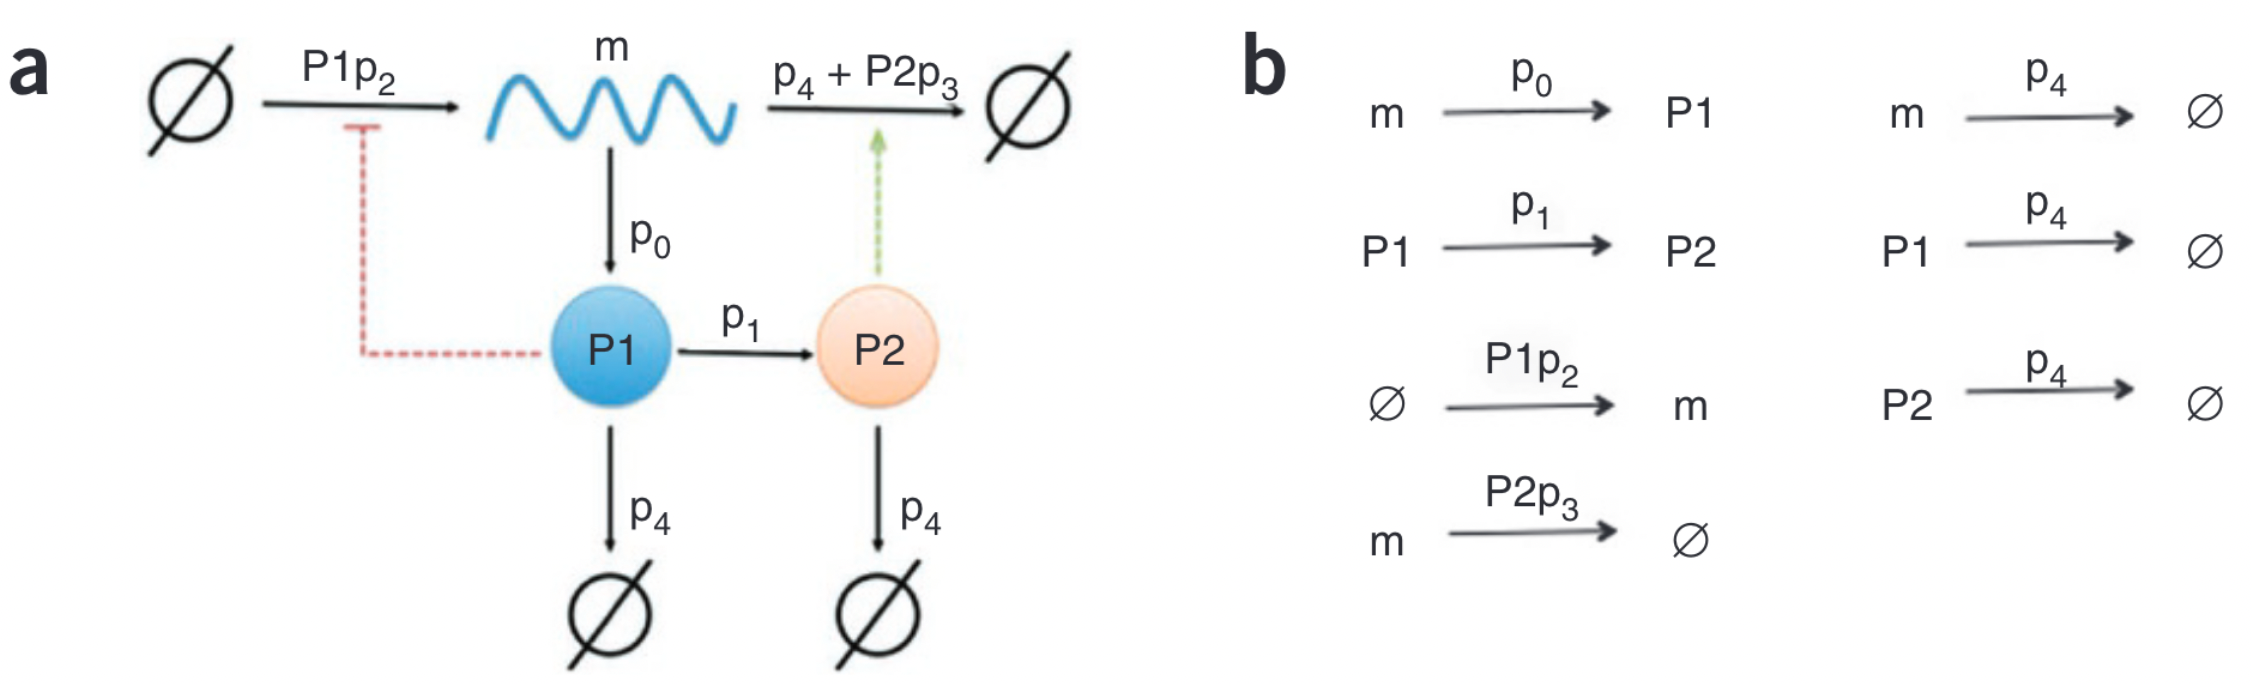

In [58]:
from IPython.display import Image
Image(filename="mRNAmodel.png")

In [59]:
import numpy as np
import roadrunner
from scipy import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math

import pypesto
import pypesto.engine as eng
import pypesto.visualize as visualize
import pypesto.optimize as optimize
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.store as store
from pypesto.ensemble import Ensemble
import os 

Set up the model properties from the original bngl and sbml files

In [60]:
seed = 12345 
np.random.seed(seed = seed) # seeds used for reproducability 
# sets framework for parallel computing by storing the # of 
## processors to be used to the # of cores available on comp
engine = eng.MultiProcessEngine(n_procs = os.cpu_count()) 
print(os.cpu_count()) # shows how many cores you have

10


In [61]:
# model system params
mrnaSBML = "mRNA_sbml.xml" # name of sbml file 
species = ["mRNA", "p1", "p2"] # names of species in order from bngl file 
speciesID = ["S1", "S2", "S3"] # these are the IDs created from the sbml file 
time = 16 # t_end from bngl
colors = ["tab:pink", "tab:purple", "tab:cyan"] # tableau color palette 
params = ["param0", "param1", "param2", "param3", "param4"] # names of parameters in order from bngl file 

# synthetic data params
gausNoise = 0.01 # 1% gausian noise, should it be 10% noise? i do 10 later
points = 17 # not sure yet 

# optimizaiton params 
logError = False


load the model with libroadrunner

In [62]:
rr = roadrunner.RoadRunner(mrnaSBML) # uses libroadrunner to load the sbml file for the mRNA model 
# integrator is a numerical ODE solver
# abs and rel tolerance are parameters controlling error tolerence of the solution
rr.integrator.absolute_tolerance = 5e-10 # in absolute terms:  small value increases accuracy but slower
rr.integrator.relative_tolerance = 1e-8 # rel terms (proportion of value being calc): small val inc acc

# list of the true parameter values 
trueParams = [rr[params[0]], rr[params[1]], rr[params[2]], rr[params[3]], rr[params[4]]] 


Simulate the model and visualize the species

        time,    [S1],    [S2],     [S3]
 [[        0,      10,       5,        0],
  [ 0.100629, 8.90447,  12.519, 0.430351],
  [ 0.201258, 12.1973, 20.4867,  1.17367],
  [ 0.301887, 16.8798, 31.1968,  2.29012],
  [ 0.402516, 21.6251, 44.9102,  3.88698],
  [ 0.503145, 25.1582,  60.646,  6.04272],
  [ 0.603774, 26.6745, 76.5385,  8.75737],
  [ 0.704403, 26.3087,  90.676,  11.9367],
  [ 0.805031, 24.7876, 101.876,  15.4197],
  [  0.90566, 22.8047, 109.821,   19.026],
  [  1.00629, 20.7746, 114.757,  22.5925],
  [  1.10692, 18.8858, 117.164,  25.9902],
  [  1.20755, 17.2022, 117.566,  29.1271],
  [  1.30818, 15.7306, 116.441,  31.9439],
  [  1.40881, 14.4547, 114.195,  34.4085],
  [  1.50943, 13.3512, 111.156,  36.5092],
  [  1.61006, 12.3965, 107.585,  38.2495],
  [  1.71069, 11.5688, 103.686,  39.6435],
  [  1.81132, 10.8497, 99.6122,  40.7127],
  [  1.91195, 10.2234, 95.4835,  41.4828],
  [  2.01258, 9.67679, 91.3874,   41.982],
  [  2.11321, 9.19908, 87.3883,  42.2395],
  [  2.21384,

Text(0.5, 1.0, 'True Solution for mRNA Self-Regulation Model')

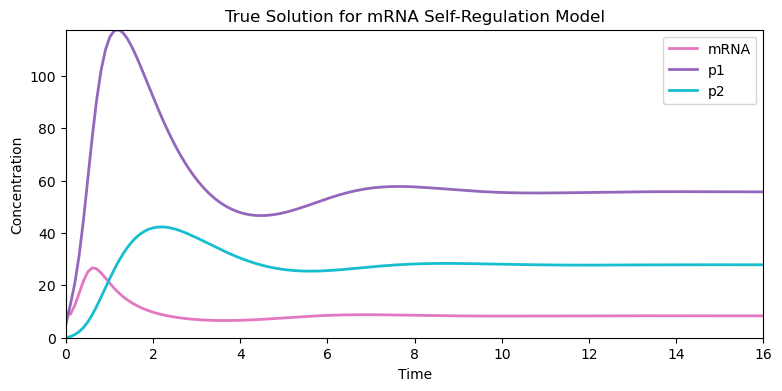

In [63]:
plt.figure(figsize=(9,4), dpi=100)
# simulates model from 0 to time with time*10 # of points
# in res: first col rep time points, other cols rep the trajectories (value over time) of species in model 
res = rr.simulate(0, time, time*10)  
ts = res[:,0] # first col in res is the time points 
trajs = np.transpose(res[:,1:]) # rest of cols, so trajs has species as rows and time as cols bc transposed

print(res)

for label, color, traj in zip(species, colors, trajs):
    plt.plot(ts, traj, color=color, label=label, lw=2)

plt.legend()
plt.margins(x=0, y=0)
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("True Solution for mRNA Self-Regulation Model")


Text(0.5, 1.0, 'True Solution for mRNA Self-Regulation Model')

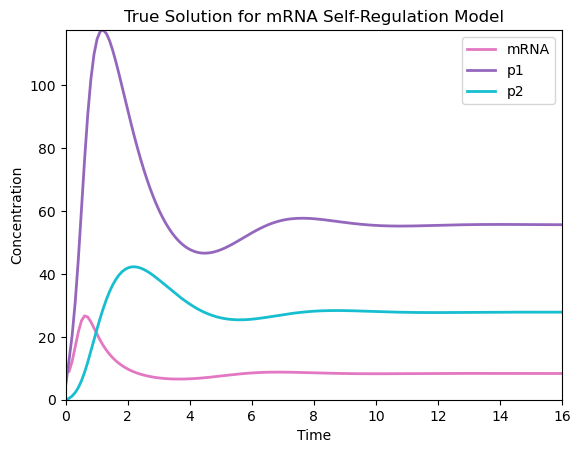

In [64]:
# use this one to edit figure

for label, color, traj in zip(species, colors, trajs):
    plt.plot(ts, traj, color=color, label=label, lw=2)

plt.legend()
plt.margins(x=0, y=0)
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("True Solution for mRNA Self-Regulation Model")

In [65]:
print(ts)
print(trajs)

[ 0.          0.10062893  0.20125786  0.30188679  0.40251572  0.50314465
  0.60377358  0.70440252  0.80503145  0.90566038  1.00628931  1.10691824
  1.20754717  1.3081761   1.40880503  1.50943396  1.61006289  1.71069182
  1.81132075  1.91194969  2.01257862  2.11320755  2.21383648  2.31446541
  2.41509434  2.51572327  2.6163522   2.71698113  2.81761006  2.91823899
  3.01886792  3.11949686  3.22012579  3.32075472  3.42138365  3.52201258
  3.62264151  3.72327044  3.82389937  3.9245283   4.02515723  4.12578616
  4.22641509  4.32704403  4.42767296  4.52830189  4.62893082  4.72955975
  4.83018868  4.93081761  5.03144654  5.13207547  5.2327044   5.33333333
  5.43396226  5.53459119  5.63522013  5.73584906  5.83647799  5.93710692
  6.03773585  6.13836478  6.23899371  6.33962264  6.44025157  6.5408805
  6.64150943  6.74213836  6.8427673   6.94339623  7.04402516  7.14465409
  7.24528302  7.34591195  7.44654088  7.54716981  7.64779874  7.74842767
  7.8490566   7.94968553  8.05031447  8.1509434   8.

Text(0.5, 1.0, 'True Solution for mRNA Self-Regulation Model showing mRNA Concentration')

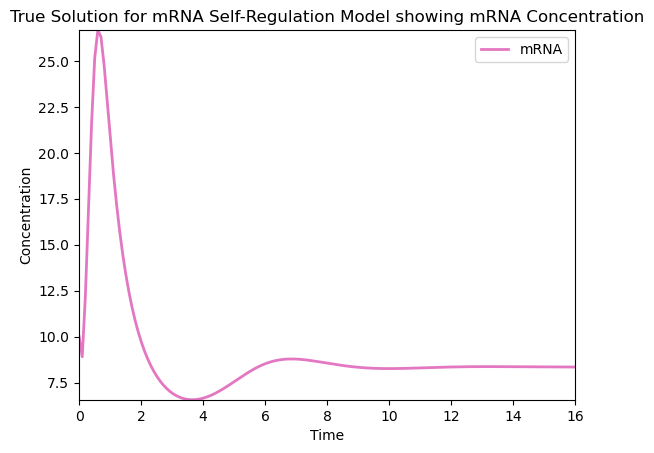

In [66]:
# only plotting the mRNA concentration to compare to the paper 
plt.plot(ts, trajs[0,], label="mRNA", color = "tab:pink", lw=2)
plt.legend()
plt.margins(x=0, y=0)
#plt.ylim(0,30)
plt.xlabel("Time")

plt.ylabel("Concentration")
plt.title("True Solution for mRNA Self-Regulation Model showing mRNA Concentration")

<function matplotlib.pyplot.show(close=None, block=None)>

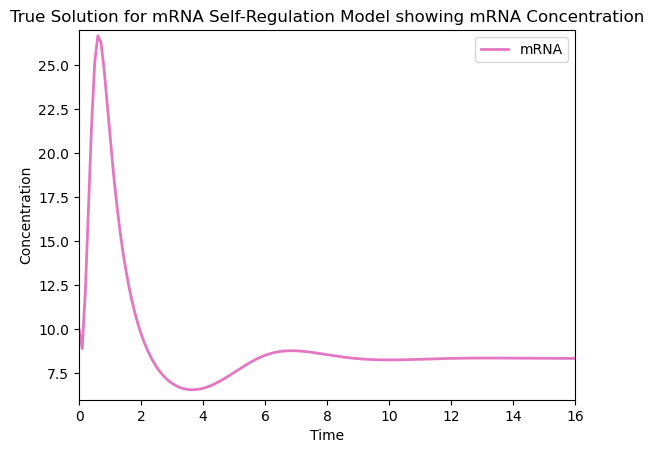

In [80]:
# only plotting the mRNA concentration making it look similar to paper figure 
plt.plot(ts, trajs[0,], label="mRNA", color = "tab:pink", lw=2)
plt.legend()
plt.margins(x=0, y=0)
plt.ylim(6,27)
plt.xlabel("Time")

plt.ylabel("Concentration")
plt.title("True Solution for mRNA Self-Regulation Model showing mRNA Concentration")
plt.show

Comapring the results to the original paper

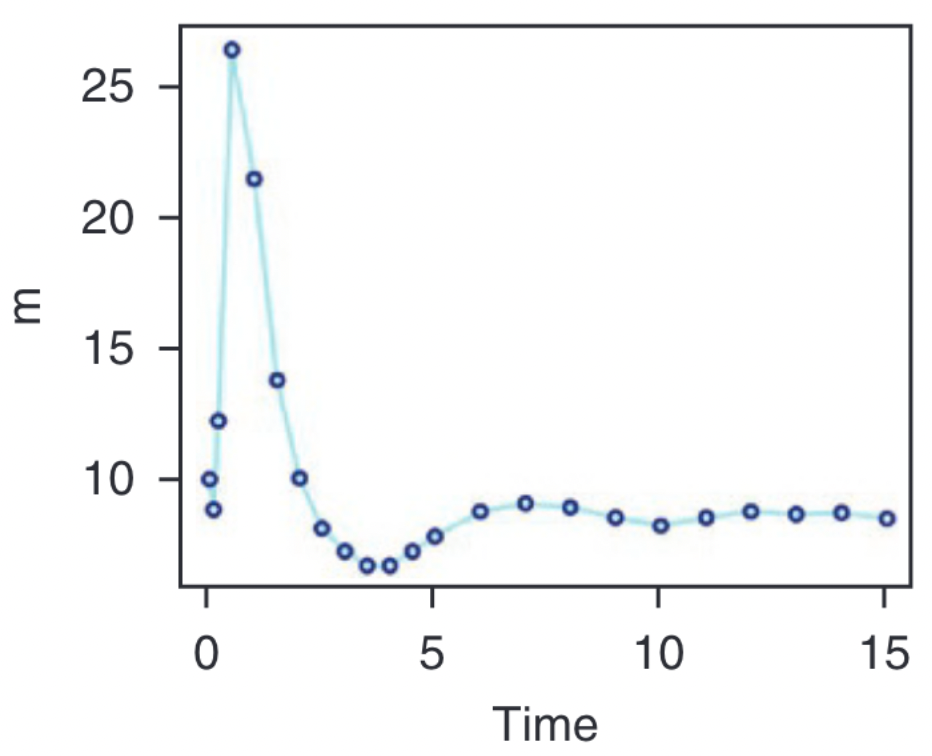

In [85]:
Image(filename="ogPaper.png", width=500, height=500)

comparing the results to Sanjana's paper

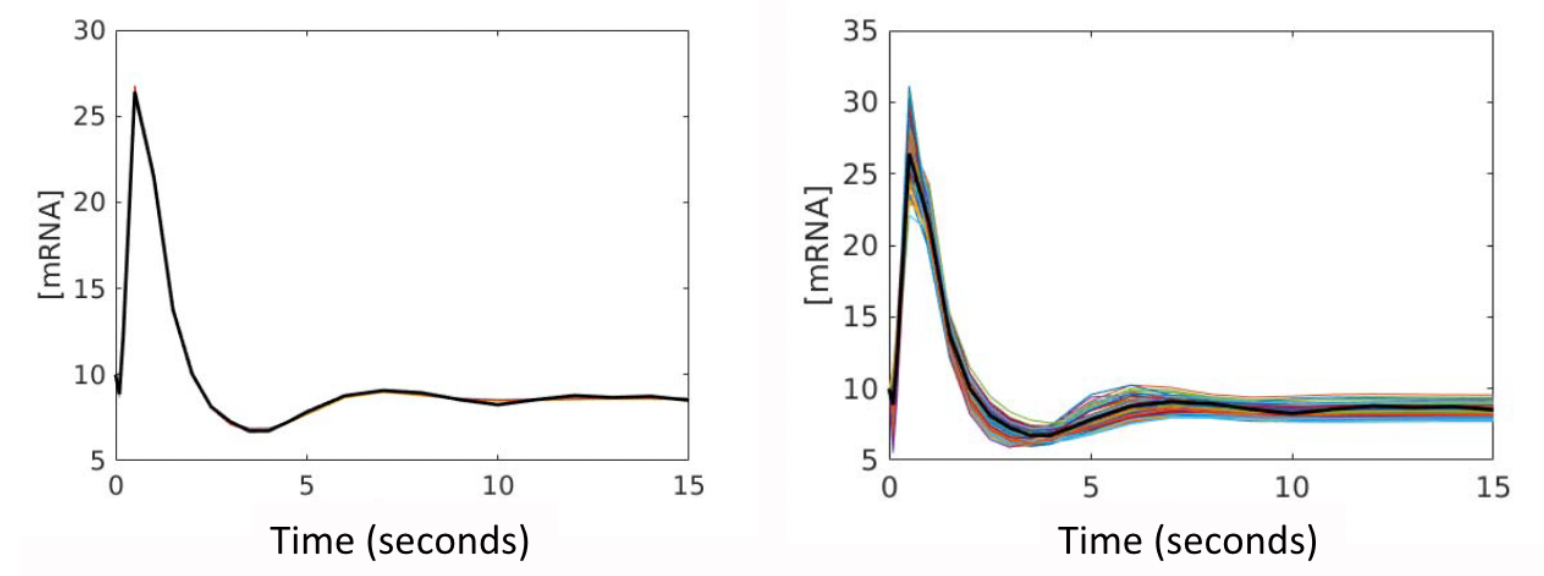

In [82]:
Image(filename="sanjanaPaper.png")

#### Creating synthetic data to save for pocoMC

Need to generate Gaussian noise

In [68]:
# function to simulation gaussian noise
def gaussianNoise(x, std, mean=0):
    
    gNoise = np.random.normal(mean, std, size = x.shape) # creates a gaussian dist the size of our data
    xNoise = x + gNoise # adds noise to our data

    # will return noisy data
    return xNoise 

In [69]:
rr.resetAll() # reset everything so we can start over and use our noisy data 

# simulates model from 0 to time with # of points
# in res: first col rep time points, other cols rep the trajectories (value over time) of species in model 
resNoise = rr.simulate(0, time, points)  
tsNoise = resNoise[:,0] # first col in res is the time points 
print(tsNoise)
trajsNoise = resNoise[:,1] # the second col bc we want the mRNA concentration
print(trajsNoise)

std = gausNoise * np.std(trajsNoise)
onePercentNoise = gaussianNoise(trajsNoise, std)


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
[10.         20.89850845  9.74113667  6.92820186  6.65159213  7.5479371
  8.5223917   8.77875741  8.5572021   8.33140491  8.26100873  8.29658953
  8.34763602  8.36851335  8.3632507   8.35193897  8.34633994]


In [70]:
print(resNoise)

    time,    [S1],    [S2],    [S3]
 [[    0,      10,       5,       0],
  [    1, 20.8985, 114.528, 22.3734],
  [    2, 9.74114, 91.8952, 41.9334],
  [    3,  6.9282,   60.36, 38.1474],
  [    4, 6.65159, 47.7849, 30.3847],
  [    5, 7.54794, 47.7215, 26.0369],
  [    6, 8.52239, 53.0903, 25.6091],
  [    7, 8.77876, 57.1159, 27.0352],
  [    8,  8.5572, 57.5737, 28.1567],
  [    9,  8.3314, 56.3831, 28.3467],
  [   10, 8.26101, 55.4419, 28.0564],
  [   11, 8.29659, 55.2473, 27.7918],
  [   12, 8.34764, 55.4687, 27.7219],
  [   13, 8.36851, 55.6916, 27.7742],
  [   14, 8.36325, 55.7576, 27.8356],
  [   15, 8.35194, 55.7181,  27.857],
  [   16, 8.34634, 55.6671, 27.8483]]



Text(0.5, 1.0, 'Comparing Original and Synthetic Data with 1 Percent Gaussian Noise')

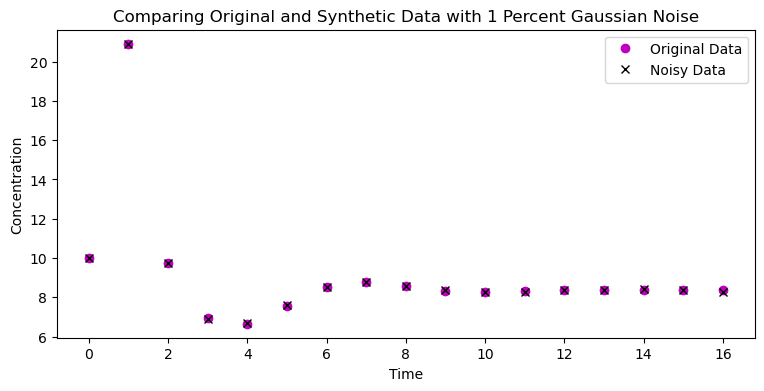

In [71]:
plt.figure(figsize=(9,4), dpi=100)
plt.plot(tsNoise, trajsNoise, 'om', label = "Original Data")
plt.plot(tsNoise, onePercentNoise, 'kx', label = "Noisy Data")

plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Comparing Original and Synthetic Data with 1 Percent Gaussian Noise')

10% noisy data

In [72]:
rr.resetAll() # reset everything so we can start over and use our noisy data 

# simulates model from 0 to time with # of points
# in res: first col rep time points, other cols rep the trajectories (value over time) of species in model 
resNoise = rr.simulate(0, time, points)  
tsNoise = resNoise[:,0] # first col in res is the time points 
print(tsNoise)
trajsNoise = resNoise[:,1] # the second col bc we want the mRNA concentration
print(trajsNoise)

gausNoise10 = .1

std = gausNoise10 * np.std(trajsNoise)
tenPercentNoise = gaussianNoise(trajsNoise, std)


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
[10.         20.89850845  9.74113667  6.92820186  6.65159213  7.5479371
  8.5223917   8.77875741  8.5572021   8.33140491  8.26100873  8.29658953
  8.34763602  8.36851335  8.3632507   8.35193897  8.34633994]


Text(0.5, 1.0, 'Comparing Original and Synthetic Data with 10 Percent Gaussian Noise')

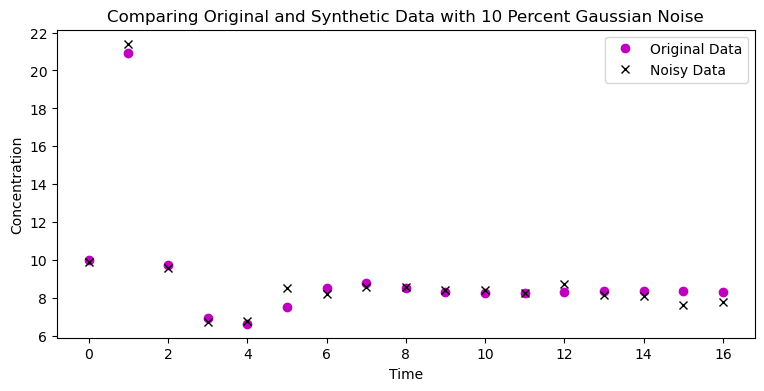

In [73]:
plt.figure(figsize=(9,4), dpi=100)
plt.plot(tsNoise, trajsNoise, 'om', label = "Original Data")
plt.plot(tsNoise, tenPercentNoise, 'kx', label = "Noisy Data")

plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Comparing Original and Synthetic Data with 10 Percent Gaussian Noise')

Save the data

In [74]:
df = pd.DataFrame()
df['Time'] = tsNoise
df['mRNA'] = tenPercentNoise
df.to_csv('synthetic_mRNA_data.csv', index=False)